# 3. Random forest regression

## 3.1 Imports

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import warnings
import pylab

from ipynb.fs.full.Functions import plotValCurve, plotLearningCurve
from numpy import loadtxt
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from statsmodels.api import qqplot

%matplotlib inline
warnings.filterwarnings('ignore')
seed = 101

In [2]:
PreparedFeatures = pd.read_csv('../Data/PreparedFeatures.csv', sep='\t')
X_train = loadtxt('../Data/X_train.csv', delimiter=',')
y_train = loadtxt('../Data/y_train.csv', delimiter=',')
X_test = loadtxt('../Data/X_test.csv', delimiter=',')
y_test = loadtxt('../Data/y_test.csv', delimiter=',')

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9550, 39), (9550,), (2388, 39), (2388,))

In [4]:
mse = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

## 3.2 Learning process visualization 

### 3.2.1 Ploting learning curve, model scalability and performance

<module 'matplotlib.pyplot' from 'C:\\Users\\brtkr\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

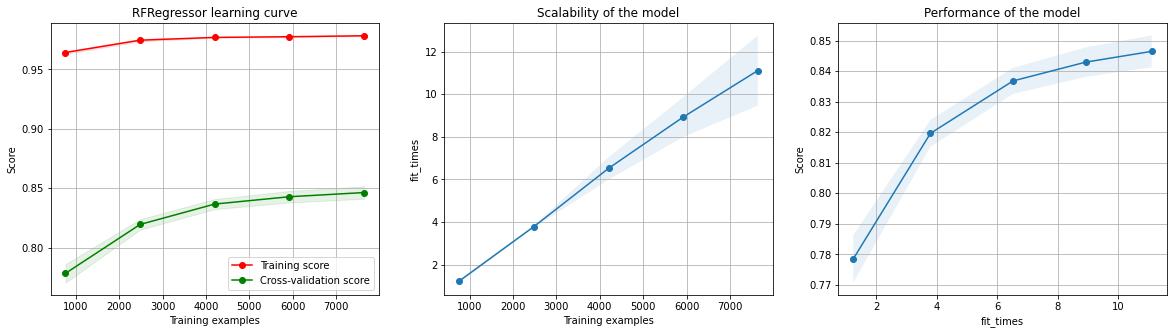

In [5]:
plotLearningCurve(estimator=RandomForestRegressor(), title = "RFRegressor learning curve", X=X_train,
                  y=y_train, cv=5, n_jobs=-1)

Learning curve shows that Random Forrest Regressor reaches generalization plateau at R2 = 0.85 and 7500 samples. Theres no reason for increasing training dataset because it would not improve model fit. 
Model scales neutrally and training takes time proportionally to rising number of expamples.
Third graph shows that model performance improves in whole fitting time.

### 3.2.2 Max depth validation curve

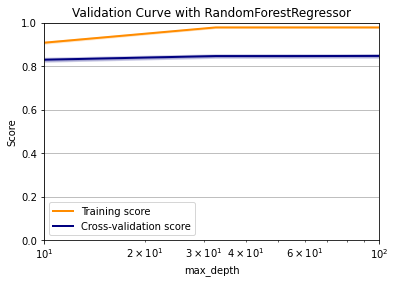

In [6]:
plotValCurve(estimator=RandomForestRegressor(), X = X_train, y = y_train, param_name='max_depth',
             param_range=np.linspace(10, 100, 5), cv=5)

### 3.2.3 N-estimators validation curve

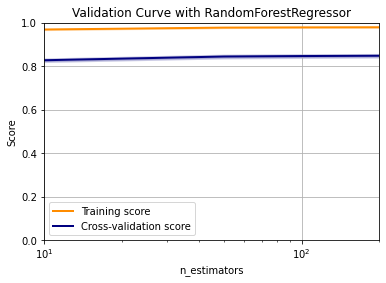

In [7]:
plotValCurve(estimator=RandomForestRegressor(), X = X_train, y = y_train, param_name='n_estimators',
             param_range=np.array([10, 50, 100, 200]), cv=5)

### 3.2.4 Max features validation curve

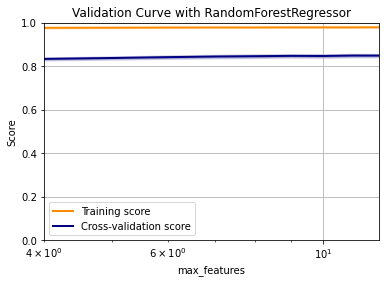

In [8]:
plotValCurve(estimator=RandomForestRegressor(), X = X_train, y = y_train, param_name='max_features',
             param_range=np.linspace(4,12,9).astype(int), cv=5)

### 3.2.5 Min samples leaf validation curve

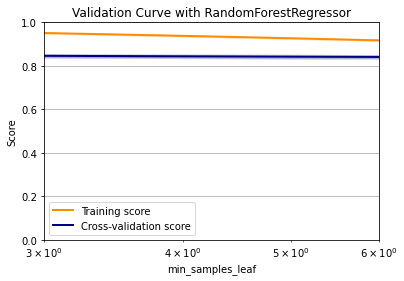

In [9]:
plotValCurve(estimator=RandomForestRegressor(), X = X_train, y = y_train, param_name='min_samples_leaf',
             param_range=np.linspace(3,6,4).astype(int), cv=5)

### 3.2.6 Min samples split validation curve

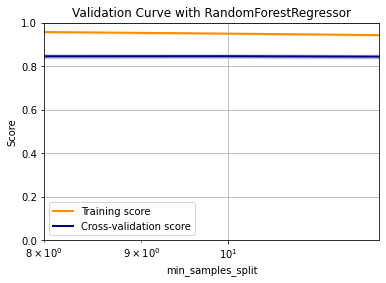

In [10]:
plotValCurve(estimator=RandomForestRegressor(), X = X_train, y = y_train, param_name='min_samples_split',
             param_range=np.array([8,10,12]), cv=5)

Parameters validation curves for better insight in model performance while adjusting hyperparameter value.

## 3.3 Hyperparameters tuning 

### 3.3.1 Random search 

At first random search is in use for preliminary determination of parameters value.
- n_estimators - number of trees in the forest
- max_features - max number of features considered for splitting a node
- max_depth - max number of levels in each decision tree 
- min_samples_split - min number of cases placed in a node before the node is split
- min_samples_leaf - min number of cases allowed in a leaf node
- bootstrap - if true sampling with replacement 

In [11]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [12]:
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(random_state=seed), 
                               param_distributions = random_grid, n_iter=100,
                               cv = 3, verbose=2, random_state=seed, 
                               n_jobs = -1, scoring=mse)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=101),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=101,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False),
                   verbose=2)

In [13]:
print('Best parameters:' + str(rf_random.best_params_))
print('Best (lowest) mse in cross-validation:' + str(rf_random.best_score_))

Best parameters:{'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
Best (lowest) mse in cross-validation:-0.033502602783693936


### 3.3.2 Grid search 

In [14]:
rfr_grid = RandomForestRegressor(random_state=seed, max_depth=50, min_samples_leaf=1, min_samples_split=2,
                                 max_features='sqrt', bootstrap=False)

param_grid = {
    'n_estimators' : [1500, 1600, 1700],
    'min_samples_split' : [2, 3]
}

gridCV = GridSearchCV(rfr_grid, param_grid=param_grid,
                      cv=5, n_jobs=-1, scoring=mse)

gridCV.fit(X_train, y_train)

print('Best parameters:' + str(gridCV.best_params_))
print('Best (lowest) mse in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'min_samples_split': 2, 'n_estimators': 1500}
Best (lowest) mse in cross-validation:-0.0328086468409481


## 3.4 Tuned model evaluation

In [15]:
param = {
    'max_depth': 50,
    'max_features' : 'sqrt',
    'min_samples_leaf' : 1,
    'min_samples_split' : 2,
    'n_estimators' : 1500,
    'bootstrap': False
}

rfr = RandomForestRegressor(**param, random_state=seed)

rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      n_estimators=1500, random_state=101)

In [16]:
print(rfr.get_params())

{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1500, 'n_jobs': None, 'oob_score': False, 'random_state': 101, 'verbose': 0, 'warm_start': False}


In [17]:
y_pred = rfr.predict(X_test)

### 3.4.1 RMSE

In [18]:
metrics.mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)

0.1739946749447827

### 3.4.2 Adjusted R-squared

In [19]:
adj_r2 = 1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
adj_r2

0.8574769515251928

Hyperparameter tuning hasn't bring better results on test set. R squared and rmse are similar to not tuned one. Default random forest hyperparameters are not providing many limitations on trees size in the forest so it is hard to increase performance of basic model. Despite little worse results trained model better generalizes data and is less overfitting.

### 3.4.3 Feature importances

In [20]:
feature_importances = dict(zip(PreparedFeatures.columns.values.tolist(), rfr.feature_importances_))

dict(sorted(feature_importances.items(), key = lambda x: x[1], reverse = True)[:5])

{'Type_u': 0.1249059552360708,
 'YearBuilt': 0.09868081649645065,
 'Latitude': 0.09539094489814796,
 'Bedrooms': 0.0952276946872916,
 'LandSize': 0.09472693483844737}

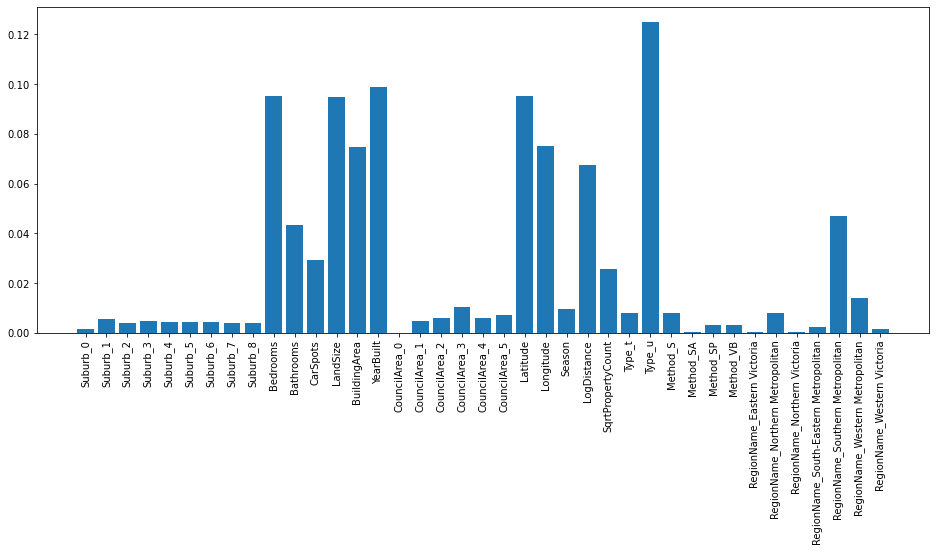

In [21]:
plt.figure(figsize=(16,6))
plt.bar(feature_importances.keys(), feature_importances.values())
plt.xticks(rotation=90)
plt.show()

Highest influence on price estimation has building type_u (twin house, flat), propably these types are cheaper than houses. At second place is building age and third bedrooms number, landsize and latitude ex aequo.

### 3.4.4 Residuals analysis

In [22]:
residuals = y_test - y_pred
residuals

array([ 0.04409488,  0.22969916,  0.03194153, ..., -0.10551358,
       -0.25098818,  0.05021275])

#### 3.4.4.1 Residuals distribution

<AxesSubplot:ylabel='Density'>

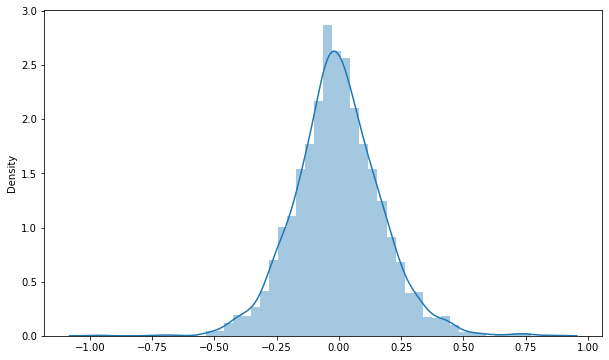

In [23]:
plt.subplots(figsize=(10,6))
sns.distplot(residuals)

No bias suggest that model random component is not correlated with estimated value, which is regression model assumption.

#### 3.4.4.2 Residuals Q-Q plot

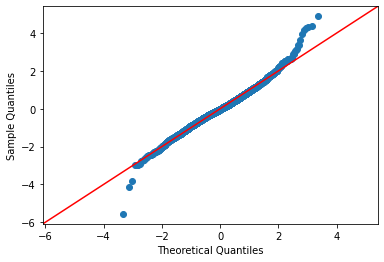

In [24]:
qq = residuals.copy()
m = qq.mean()
st = qq.std()

for i in range(0, len(qq),1):
    qq[i] = (qq[i]-m)/st
    
qqplot(qq, line='45')
pylab.show()

Deviations at both ends are caused by thin tails of distribution showed above.

#### 3.4.4.3 Heteroskedasticity plot

<AxesSubplot:>

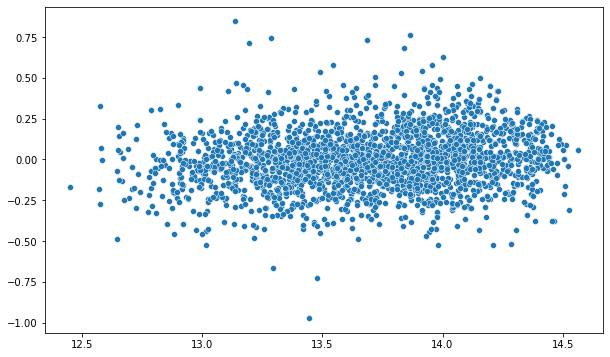

In [25]:
plt.subplots(figsize=(10,6))
sns.scatterplot(x = y_pred, y = residuals)

Random dispersion indicates that variances of error terms are constant, and error is homoskedastic.

#### 3.4.4.4 Scale location plot

Text(0.5, 0, 'Fitted value')

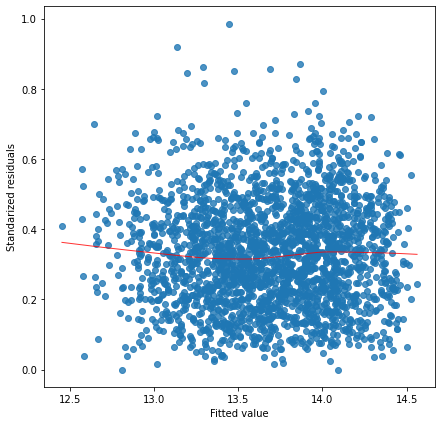

In [26]:
model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

plt.figure(figsize=(7,7))
sns.regplot(y_pred.reshape(-1), model_norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")

Residuals are spread equally along ranges of predictors. Graph also indicated that heteroskedasticity does not appears. 
Residuals analysis confirms the correctness of the model.

In [27]:
# rfr_saved_model = pickle.dump(rfr, open(r'..\Models\rfr.pkl','wb'))

Model too complex (~600MB) for github publication due to max_depth = 50.  Limited depth caused huge drop in model's performance. For project publication purposes model won't be saved to file.